In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Training data
app_train = pd.read_csv('dataset/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## DATASET APPLICATION

In [3]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [4]:
from sklearn.impute import SimpleImputer

col_num = list(app_train.select_dtypes('float64').columns)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
app_train[col_num] = imp_mean.fit_transform(app_train[col_num])

In [5]:
col_num = list(app_train.select_dtypes('int64').columns)
imp_meanN = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
app_train[col_num] = imp_meanN.fit_transform(app_train[col_num])

In [6]:

col_obj = list(app_train.select_dtypes('object').columns)
imp_cons = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NonRenseigne')
app_train[col_obj] = imp_cons.fit_transform(app_train[col_obj])

## Label Encoding et One Hot Encoding

In [7]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    106
object      16
dtype: int64

In [8]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            app_train[col] = le.fit_transform(app_train[col])
            print('transformation colonne label encoding %s.' % col)            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

transformation colonne label encoding NAME_CONTRACT_TYPE.
transformation colonne label encoding FLAG_OWN_CAR.
transformation colonne label encoding FLAG_OWN_REALTY.
3 columns were label encoded.


In [9]:
# one-hot encoding of categorical variables
print('Training Features shape avant : ', app_train.shape)

app_train = pd.get_dummies(app_train)

print('Training Features shape apres : ', app_train.shape)

Training Features shape avant :  (307511, 122)
Training Features shape apres :  (307511, 249)


In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

uint8      140
float64    106
int32        3
dtype: int64

## retour analyse EDA

In [11]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = ( app_train["DAYS_EMPLOYED"] == 365243 ).map(int)

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

app_train['DAYS_EMPLOYED_ANOM'].value_counts()

0    252137
1     55374
Name: DAYS_EMPLOYED_ANOM, dtype: int64

## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income | ratio total emprunt revenu
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income | taux endetemment
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [12]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

In [13]:
app_train[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'CREDIT_INCOME_PERCENT',
           'AMT_ANNUITY','AMT_INCOME_TOTAL', 'ANNUITY_INCOME_PERCENT',
           'AMT_ANNUITY', 'AMT_CREDIT','CREDIT_TERM',
           'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_EMPLOYED_PERCENT' ]]

,AMT_CREDIT,AMT_INCOME_TOTAL,CREDIT_INCOME_PERCENT,AMT_ANNUITY,AMT_INCOME_TOTAL,ANNUITY_INCOME_PERCENT,AMT_ANNUITY,AMT_CREDIT,CREDIT_TERM,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_EMPLOYED_PERCENT
0,406597.5,202500.0,2.007889,24700.5,202500.0,0.121978,24700.5,406597.5,0.060749,-637.0,-9461.0,0.067329
1,1293502.5,270000.0,4.790750,35698.5,270000.0,0.132217,35698.5,1293502.5,0.027598,-1188.0,-16765.0,0.070862
2,135000.0,67500.0,2.000000,6750.0,67500.0,0.100000,6750.0,135000.0,0.050000,-225.0,-19046.0,0.011814
3,312682.5,135000.0,2.316167,29686.5,135000.0,0.219900,29686.5,312682.5,0.094941,-3039.0,-19005.0,0.159905
4,513000.0,121500.0,4.222222,21865.5,121500.0,0.179963,21865.5,513000.0,0.042623,-3038.0,-19932.0,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,254700.0,157500.0,1.617143,27558.0,157500.0,0.174971,27558.0,254700.0,0.108198,-236.0,-9327.0,0.025303
307507,269550.0,72000.0,3.743750,12001.5,72000.0,0.166687,12001.5,269550.0,0.044524,0.0,-20775.0,-0.000000
307508,677664.0,153000.0,4.429176,29979.0,153000.0,0.195941,29979.0,677664.0,0.044239,-7921.0,-14966.0,0.529266
307509,370107.0,171000.0,2.164368,20205.0,171000.0,0.118158,20205.0,370107.0,0.054592,-4786.0,-11961.0,0.400134


# Ajout des donnees exterieures

In [14]:
# Read in bureau
bureau = pd.read_csv('dataset/bureau.csv')


In [15]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [16]:
# Join to the training dataframe
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
app_train['previous_loan_counts'] = app_train['previous_loan_counts'].fillna(0)
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_NonRenseigne,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,previous_loan_counts
0,100002.0,1.0,0,0,1,0.0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,0,0,2.007889,0.121978,0.060749,0.067329,8.0
1,100003.0,0.0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,4.790750,0.132217,0.027598,0.070862,4.0
2,100004.0,0.0,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,...,0,0,1,0,0,2.000000,0.100000,0.050000,0.011814,2.0
3,100006.0,0.0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,...,0,0,1,0,0,2.316167,0.219900,0.094941,0.159905,0.0
4,100007.0,0.0,0,0,1,0.0,121500.0,513000.0,21865.5,513000.0,...,0,0,1,0,0,4.222222,0.179963,0.042623,0.152418,1.0


In [17]:
app_train.isna().sum()

SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
                         ..
CREDIT_INCOME_PERCENT     0
ANNUITY_INCOME_PERCENT    0
CREDIT_TERM               0
DAYS_EMPLOYED_PERCENT     0
previous_loan_counts      0
Length: 255, dtype: int64

# BASELINE

In [18]:
import re
from collections import Counter

app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = app_train.drop(columns='TARGET').copy()
y = app_train['TARGET'].copy()


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1944)

In [21]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0.0: 226148, 1.0: 19860})
y_val Counter({0.0: 56538, 1.0: 4965})


### definition metrique et fonction evaluation

In [22]:
# il est important de faire ressortir les FNs car perte de capital
# trouver les TP est interessant aussi car interet
# les FP sont moins risqués car perte d'interet seulement
def custom_metric(y, y_pred):
    TP = np.sum( (y==1) & (y_pred==1) )
    FP = np.sum( (y==0) & (y_pred==1) )
    TN = np.sum( (y==0) & (y_pred==0) )
    FN = np.sum( (y==1) & (y_pred==0) )
# Fowlkes–Mallows index 
# https://en.wikipedia.org/wiki/Confusion_matrix
# https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index
# Positive predictive value PPV
    PPV = TP / (TP + FP)
# Positive predictive value TPR
    TPR = TP / (TP + FN)
    FMI = np.sqrt( PPV * TPR )
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred,2)

In [23]:
from sklearn.metrics import make_scorer

custom_scorer = make_scorer(custom_metric, greater_is_better=True )
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True )

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score

def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(conf_mat)
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, yval_pred,2):.3}')
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()
#    print(classification_report(yval, yval_pred))

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## comparaison hasard Dummy

[[52016  4522]
 [ 4564   401]]
Accuracy score    : 0.852
precision score   : 0.0815
recall score      : 0.0808
F1 score          : 0.0811
F2 score          : 0.0809
ROCAUC score      : 0.5
custom metric FMI : 0.0811



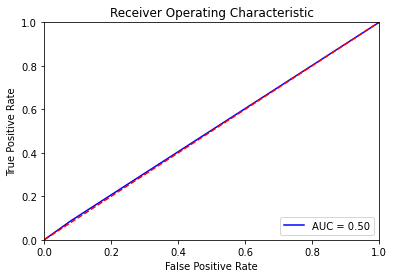

In [25]:
from sklearn.dummy import DummyClassifier

dummyCls = DummyClassifier(strategy='stratified')
dummyCls.fit(X_train, y_train)

model_eval(dummyCls, X_val, y_val)

In [30]:
from lightgbm import LGBMClassifier

lgbmc10 = LGBMClassifier(is_unbalance=True)

lgbmc10.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.804936	training's binary_logloss: 0.546661	valid_1's auc: 0.763736	valid_1's binary_logloss: 0.556667


LGBMClassifier(is_unbalance=True)

[[40141 16397]
 [ 1568  3397]]
Accuracy score    : 0.708
precision score   : 0.172
recall score      : 0.684
F1 score          : 0.274
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



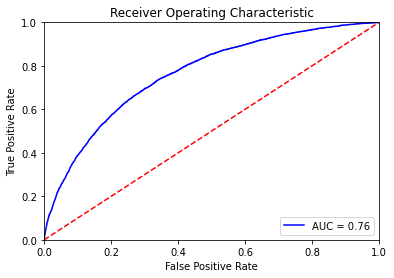

In [31]:
model_eval(lgbmc10, X_val, y_val)

In [44]:
y_val.shape

(61503,)

In [43]:
F2-Measure = (5 * Precision * Recall) / (4 * Precision + Recall)

(61503,)

In [56]:

def custom_lightgbm_valid(y_true, y_pred):
    TP = np.sum( (y_true==1) & (y_pred==1) )
    FP = np.sum( (y_true==0) & (y_pred==1) )
    TN = np.sum( (y_true==0) & (y_pred==0) )
    FN = np.sum( (y_true==1) & (y_pred==0) )
    precision  = TP / ( TP + FP )
    recall  = TP / ( TP + FN )
    f1_score = 2 * precision * recall / (precision + recall)
    f2_score = (5 * precision * recall) / (4 * precision + recall)
    return "F2 Score", f2_score, True
 
y_pred = lgbmc10.predict(X_val)
custom_lightgbm_valid(y_val, y_pred)

('F2 Score', 0.42833005497553833, True)

In [61]:
from sklearn.metrics import make_scorer

def custom_metric_light_gbm(y, y_pred):
    chaine, f2_score, dum = custom_lightgbm_valid(y, y_pred)
    return f2_score

y_pred = lgbmc10.predict(X_val)
print(custom_metric_light_gbm(y_val, y_pred))

custom_scorer_lgbm_f2 = make_scorer(custom_metric_light_gbm, greater_is_better=True )

0.42833005497553833


[[40141 16397]
 [ 1568  3397]]
Accuracy score    : 0.708
precision score   : 0.172
recall score      : 0.684
F1 score          : 0.274
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



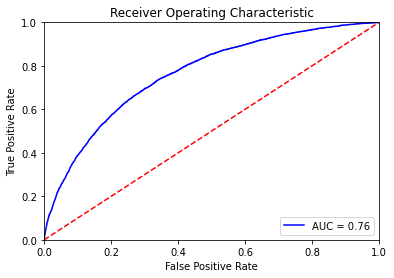

In [57]:
lgbmc10_custom = LGBMClassifier(is_unbalance=True)

lgbmc10_custom.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= custom_lightgbm_valid, verbose= 200)

model_eval(lgbmc10_custom, X_val, y_val)

{'num_leaves': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]), 'min_child_samples': array([100, 200, 300, 400]), 'min_child_weight': [1e-05, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0], 'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'colsample_bytree': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10, 50, 100], 'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50, 100]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.8min finished


{'subsample': 0.8000000000000003, 'reg_lambda': 100, 'reg_alpha': 0, 'num_leaves': 50, 'min_child_weight': 100.0, 'min_child_samples': 400, 'colsample_bytree': 0.30000000000000004}
[[40514 16024]
 [ 1604  3361]]
Accuracy score    : 0.713
precision score   : 0.173
recall score      : 0.677
F1 score          : 0.276
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



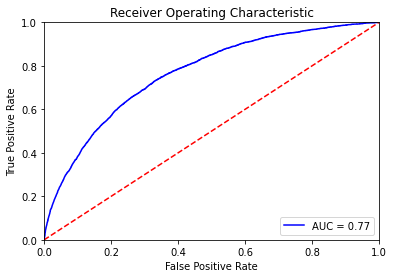

In [62]:
from sklearn.model_selection import RandomizedSearchCV

random_grid ={
            'num_leaves': np.arange(50,500,50),
            'min_child_samples': np.arange(100,500,100), 
            'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'subsample': np.arange(0.2,1,.1), 
            'colsample_bytree': np.arange(0.2,1,.1),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc'), scoring=custom_scorer_lgbm_f2, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=3, n_jobs = -1)
# Fit the random search model
lgbm_random.fit(X_train, y_train)

print(lgbm_random.best_params_)

model_eval(lgbm_random.best_estimator_, X_val, y_val)

In [63]:
model_eval_score(lgbm_random.best_estimator_, X_val, y_val)

[[40514 16024]
 [ 1604  3361]]
Accuracy score    : 0.713
precision score   : 0.173
recall score      : 0.677
F1 score          : 0.276
F2 score          : 0.428
ROCAUC score      : 0.697
custom metric FMI : 0.343



{'num_leaves': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]), 'min_child_samples': array([100, 200, 300, 400]), 'min_child_weight': [1e-05, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0], 'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'colsample_bytree': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10, 50, 100], 'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50, 100]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.6min finished


{'subsample': 0.7000000000000002, 'reg_lambda': 50, 'reg_alpha': 5, 'num_leaves': 100, 'min_child_weight': 100.0, 'min_child_samples': 100, 'colsample_bytree': 0.4000000000000001}
[[41906 14632]
 [ 1732  3233]]
Accuracy score    : 0.734
precision score   : 0.181
recall score      : 0.651
F1 score          : 0.283
F2 score          : 0.428
ROCAUC score      : 0.696
custom metric FMI : 0.343



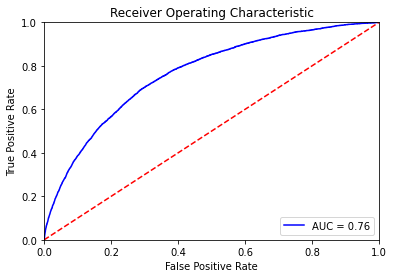

In [64]:
from sklearn.model_selection import RandomizedSearchCV

random_grid ={
            'num_leaves': np.arange(50,500,50),
            'min_child_samples': np.arange(100,500,100), 
            'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'subsample': np.arange(0.2,1,.1), 
            'colsample_bytree': np.arange(0.2,1,.1),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc'), scoring=custom_scorer, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=3, n_jobs = -1)
# Fit the random search model
lgbm_random.fit(X_train, y_train)

print(lgbm_random.best_params_)

model_eval(lgbm_random.best_estimator_, X_val, y_val)